#Clustering T1 metrics

In [1]:
import pandas as pd
import scipy.cluster as clust
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn import feature_selection as fs
from sklearn.ensemble import ExtraTreesClassifier as ETC
import numpy as np
import networkx as nx
from networkx.algorithms import clique

In [8]:
raw_metrics = pd.read_csv('/Users/labc02/Documents/PREEMACS/data_metrics.csv')

In [10]:
raw_metrics.dropna(how = 'any', axis = 1, inplace = True)
#raw_metrics = raw_metrics.astype({'Class_1' :'int32', 'Class_2':'int32', 'Class_3':'int32'})
raw_metrics

,Unnamed: 0,SITE,Class Ima,cjv,cnr,efc,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
0,1,AMU,2,0.437439,3.112410,0.874622,4.175593,4.25266,4.39958,3.87454,...,1004.170715,1000.151001,86284,874.981107,1151.646039,85.054184,0.238507,0.487515,0.502867,0.550889
1,2,AMU,2,0.435989,3.129647,0.823220,5.194107,5.29722,5.53190,4.75320,...,1008.314941,1000.044495,136961,911.091309,1131.242798,69.707794,0.179574,0.469644,0.510231,0.708890
2,3,AMU,3,0.427700,3.171547,0.763682,4.421860,4.41628,4.82080,4.02850,...,1002.342102,1000.118774,51588,880.193790,1133.884430,79.106232,0.228725,0.518993,0.521569,0.439233
3,4,AMU,3,0.450975,2.913519,0.892556,4.285407,4.26446,4.48902,4.10274,...,1010.344543,1000.088013,92034,875.890634,1184.610614,95.618935,0.273287,0.487455,0.522509,0.579871
4,5,ECNU,3,0.408896,3.447340,0.755326,5.767960,5.55016,6.68102,5.07270,...,1005.318970,1000.067749,105402,884.939569,1147.680914,81.727478,0.153531,0.484158,0.469426,0.756391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,258,MCGILL,1,0.474673,2.773044,0.743106,4.224093,4.33228,3.85930,4.48070,...,1007.641113,1000.132568,70146,874.324951,1174.065430,89.039024,0.091934,0.305783,0.249530,0.447883
92,259,Rockefeller,3,0.692962,1.689737,0.666788,3.302700,3.50538,3.17240,3.23032,...,1002.922913,999.891357,48416,870.783783,1144.905487,83.143356,0.103943,0.339155,0.299565,0.470622
93,260,Rockefeller,3,0.652824,2.000188,0.696407,3.149093,3.36616,3.08060,3.00052,...,1002.679688,999.839478,55429,865.056958,1147.586328,86.420166,0.084818,0.342317,0.327386,0.503512
94,261,Rockefeller,3,0.505328,2.491943,0.689386,3.769960,4.09906,3.56964,3.64118,...,1006.810364,999.853882,86677,876.977747,1161.221387,86.986626,0.111371,0.377874,0.296634,0.669626


In [ ]:
# DO NOT RUN AGAIN
# This creates a shitload of figures
fig_num = 0
for ii in range(3, 31, 4):
    for jj in range(31, 62, 4):
        g = sns.PairGrid(std_df, hue= 'Class', x_vars = std_df.columns[ii:ii+4], y_vars = std_df.columns[jj:jj+4])
        g.map(plt.scatter)
        g.add_legend()
        g.savefig(f'/Users/labc02/Documents/PREEMACS/Std_VarGrid{fig_num}')
        plt.close()
        fig_num += 1

In [12]:
# Data standarization
std_df = raw_metrics.copy()
wk_slice = raw_metrics.iloc[:,3:].copy()
wk_slice = (wk_slice - wk_slice.mean()) / wk_slice.std()
std_df.iloc[:,3:] = wk_slice
std_df

,Unnamed: 0,SITE,Class Ima,cjv,cnr,efc,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
0,1,AMU,2,0.153407,-0.204505,1.906592,-0.523548,-0.427659,-0.533951,-0.548210,...,-0.393496,1.179999,-0.454523,-0.280346,-0.022437,0.069437,1.137959,0.761184,0.506961,-0.670135
1,2,AMU,2,0.133589,-0.177359,1.077684,1.043747,1.031319,0.946415,1.025474,...,0.087781,0.149810,1.274052,0.543694,-0.272903,-0.341085,0.069392,0.492194,0.588758,0.628463
2,3,AMU,3,0.020303,-0.111370,0.117573,-0.144591,-0.199125,0.016741,-0.272467,...,-0.605857,0.868281,-1.637992,-0.161392,-0.240475,-0.089673,0.960584,1.234958,0.714705,-1.587829
3,4,AMU,3,0.338408,-0.517734,2.195800,-0.354566,-0.411178,-0.417019,-0.139503,...,0.323483,0.570742,-0.258393,-0.259590,0.382229,0.352049,1.768584,0.760272,0.725153,-0.431938
4,5,ECNU,3,-0.236717,0.322969,-0.017175,1.926795,1.384610,2.448744,1.597701,...,-0.260147,0.374736,0.197585,-0.053092,-0.071112,-0.019554,-0.402825,0.710651,0.135488,1.018865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,258,MCGILL,1,0.662314,-0.738964,-0.214238,-0.448916,-0.316451,-1.240299,0.537425,...,0.009528,1.001704,-1.004985,-0.295320,0.252778,0.176033,-1.519704,-1.974118,-2.307182,-1.516735
92,259,Rockefeller,3,3.645826,-2.445039,-1.444953,-1.866761,-1.471414,-2.138334,-1.702012,...,-0.538406,-1.331429,-1.746188,-0.376130,-0.105183,0.018322,-1.301965,-1.471827,-1.751379,-1.329845
93,260,Rockefeller,3,3.097225,-1.956117,-0.967305,-2.103132,-1.665868,-2.258351,-2.113585,...,-0.566652,-1.833242,-1.506977,-0.506817,-0.072274,0.105978,-1.648737,-1.424233,-1.442338,-1.059528
94,261,Rockefeller,3,1.081295,-1.181663,-1.080531,-1.147739,-0.642198,-1.618993,-0.966159,...,-0.086948,-1.693915,-0.441118,-0.234782,0.095108,0.121131,-1.167274,-0.889056,-1.783941,0.305756


In [20]:
if raw_metrics.shape == std_df.shape:
    ch_size = raw_metrics.iloc[:,3:].shape[1], std_df.iloc[:,3:].shape[1]

In [23]:
# Calculate Pairwise Calinsky-Harabaz Score Between All Metrics Pairs
which_df = raw_metrics
cols = []
ch_score = np.empty(ch_size)
col = 0
for ii in which_df.columns[3:]:
    cols.append(ii)
    row = 0
    for jj in which_df.columns[3:]:
        X_ = pd.concat([which_df[jj], which_df[ii]], axis = 1)
        ch_score[row, col] = np.round(metrics.calinski_harabasz_score(X_, which_df['Class Ima']), 2)
        row +=1
    col += 1

In [24]:
np.fill_diagonal(ch_score, 0) # set diagonal to zero
CH_df = pd.DataFrame(data = ch_score, index = cols, columns  = cols)

Text(0.5, 1.0, 'Pairwise Calinski-Harabaz Score of all Metrics \n for Cluster Evaluation based on Class')

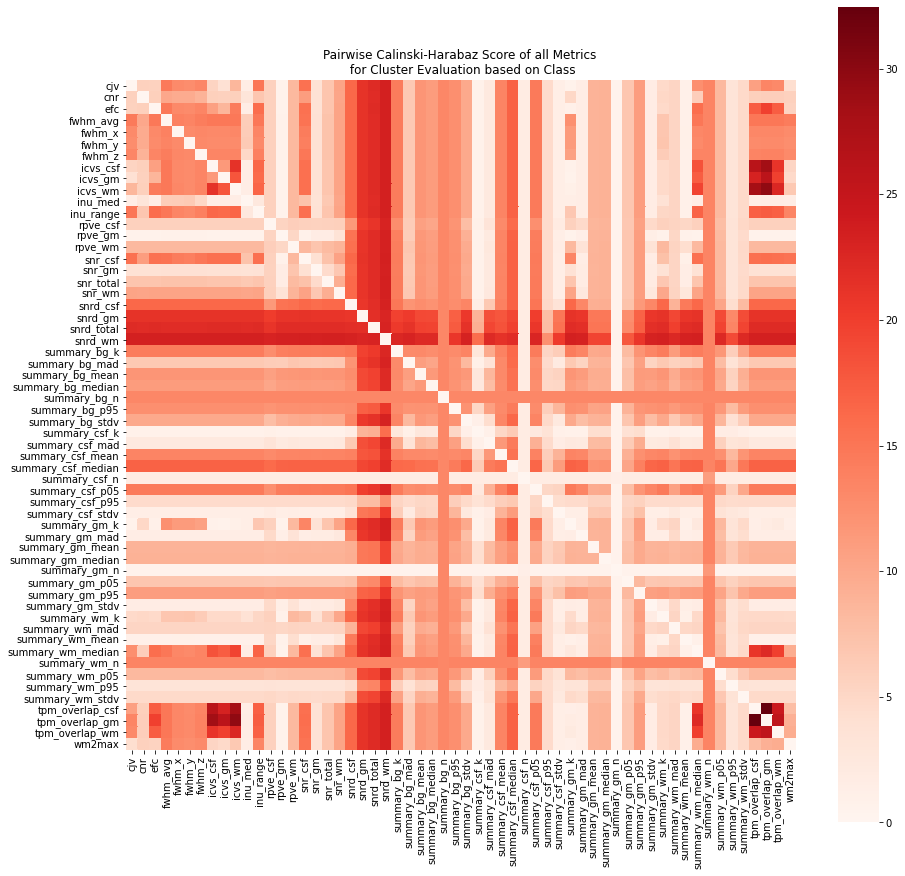

In [136]:
CHS_figure = plt.figure(figsize = (15,15))
sns.heatmap(CH_df, square = True, cmap = 'Reds')
plt.title('Pairwise Calinski-Harabaz Score of all Metrics \n for Cluster Evaluation based on Class')

In [23]:
CHS_figure.savefig('/Users/labc02/Documents/PREEMACS/Std_metrics_Calkinsky_Harabaz_eval_Class_3.png', ppi = 600)

In [26]:
# Threshold detection by minimizing edge density
p_ch = []
for ii in np.arange(0.0, max(CH_df.max()), 0.01):
    wk_df = CH_df[CH_df > ii].dropna(axis = 0, how = 'all')
    wk_df = wk_df[wk_df > ii].dropna(axis = 1, how = 'all')
    n = wk_df.shape[0]
    max_ed = (n*(n-1))
    wk_sum = wk_df.notnull().sum().sum()
    wk_p = wk_sum / max_ed
    p_ch.append(wk_p)

In [28]:
# Get the values of the vector
k = np.array(p_ch)
k = k[~np.isnan(k)]
chs_vec = np.arange(0.0, max(CH_df.max()), 0.01)
k_min = np.argmin(k[k>0])
thd = chs_vec[k_min] # threshold value

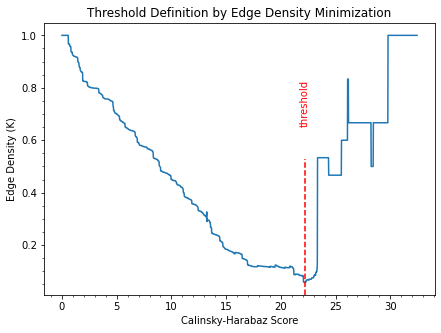

In [29]:
th_fig = plt.figure(figsize=(7,5))
ax = th_fig.add_subplot()
plt.plot(np.arange(0.0, max(CH_df.max()), 0.01), p_ch)
plt.title('Threshold Definition by Edge Density Minimization')
plt.xlabel('Calinsky-Harabaz Score')
plt.ylabel('Edge Density (K)')
plt.axvline(thd, 0, .5, color = 'r', linestyle = '--')
plt.annotate('threshold', xy = (chs_vec[k_min], .6), xytext = (-5, 15), textcoords = 'offset points', color = 'r', rotation = 90)
plt.minorticks_on()

In [90]:
th_fig.savefig('/Users/labc02/Documents/PREEMACS/threshold_edge_min_std_metrics.png', ppi = 600)

In [30]:
sig_int = []
for column in CH_df.columns:
    sum_int = CH_df[CH_df >thd][column].count()
    sig_int.append(sum_int)

In [31]:
int_df = pd.DataFrame(data = zip(sig_int, CH_df.columns), columns = ['count', 'metric'])
int_df.sort_values(by = 'count', inplace = True, ascending = False)

In [32]:
p_ = []
deg = []
for ii in range(1,max(int_df['count']), 1):
    num = int_df[int_df['count']>ii].shape[0]
    p = num/int_df['count'].shape[0]
    p_.append(p)
    deg.append(ii)

In [33]:
s, b = np.polyfit(np.log10(deg), np.log10(p_), 1)

In [34]:
s, b

(-0.4896731482357714, -1.0903989296598544)

In [35]:
mtr = int_df['count'].values.shape[0]

<ipython-input-36-c320c6f1ac42>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


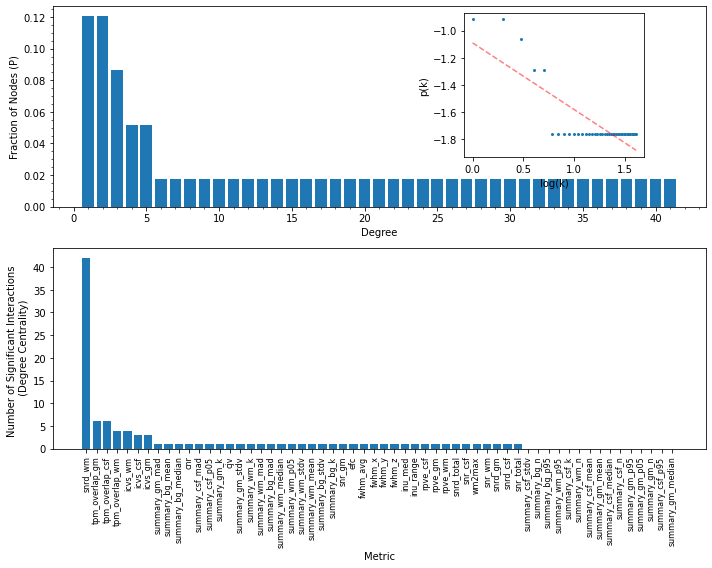

In [36]:
inter_fig = plt.figure(figsize = (10, 8))
ax = inter_fig.add_subplot(212)
plt.bar(x = np.arange(0,mtr, 1), height = int_df['count'].values)
plt.xticks(np.arange(0,mtr, 1))
ax.set_xticklabels(int_df['metric'], rotation = 90, fontsize = 8)
plt.xlabel('Metric')
plt.ylabel('Number of Significant Interactions \n (Degree Centrality)')
ax_1 = inter_fig.add_subplot(211)
plt.bar(deg, p_)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes (P)')
plt.minorticks_on()
a = plt.axes([.65, .72, .25, .25])
plt.scatter(np.log10(deg), np.log10(p_), s = 4)
plt.plot(np.log10(deg), (s*np.log10(deg)+b), 'r--', alpha = .5)
plt.ylabel('p(k)')
plt.xlabel('log(k)')
plt.tight_layout()

In [98]:
inter_fig.savefig('/Users/labc02/Documents/PREEMACS/Degree_n_cent_std_metrics.png', ppi = 600, bbox_inches='tight')

In [37]:
CH_g = nx.Graph()
CH_g.add_nodes_from(CH_df.columns)

In [38]:
for ii in CH_df.columns:
    for jj in CH_df.index:
        if CH_df.loc[ii, jj] > thd:
            CH_g.add_edge(ii, jj, weight = (1/CH_df.loc[ii, jj]))

In [39]:
nodes = sorted(CH_g.nodes)
sizes = [CH_g.degree[ii]*10 if CH_g.degree[ii]>0 else 5 for ii in nodes]

In [40]:
pos = nx.spring_layout(CH_g, seed = 25)

In [41]:
num_nodes = []
clique_idx = []
for ii, jj in enumerate(clique.find_cliques(CH_g)):
    num_nodes.append(len(jj))
    clique_idx.append(ii)

In [42]:
all_cliques = list(clique.find_cliques(CH_g))
max_clique = all_cliques[np.argmax(np.array(num_nodes))]
max_pos = nx.spring_layout(CH_g.subgraph(max_clique), seed = 102)
max_nodes = sorted(max_clique)
max_sizes = [CH_g.degree[ii]*100 for ii in max_nodes]

In [43]:
x_values, y_values = zip(*max_pos.values())
x_max = max(x_values)
x_min = min(x_values)
y_max = max(y_values)
y_min = min(y_values)
x_margin = (x_max - x_min) * 0.25
y_margin = (y_max - y_min) * 0.25

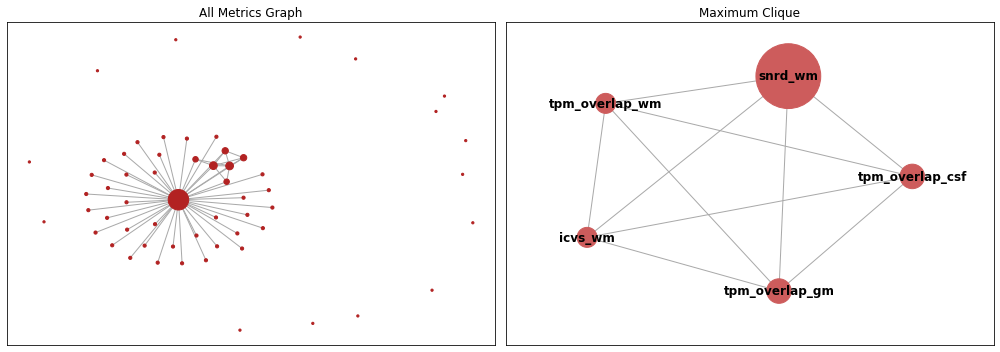

In [44]:
CHg_fig = plt.figure(figsize = (14,5))
ax_1 = CHg_fig.add_subplot(121)
nx.draw_networkx(CH_g, pos = pos, nodelist = nodes, node_size = sizes, node_color = 'firebrick', node_edge = 'k', with_labels = False, edge_color = 'darkgray', ax = ax_1)
ax_1.set_title('All Metrics Graph')
ax_2 = CHg_fig.add_subplot(122)
nx.draw_networkx(CH_g.subgraph(max_clique), pos = max_pos, nodelist = max_nodes, node_size = max_sizes, node_color = 'indianred', edge_color = 'darkgray', font_weight='bold', ax = ax_2)
ax_2.set_title('Maximum Clique')
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)
plt.tight_layout()

In [107]:
CHg_fig.savefig('/Users/labc02/Documents/PREEMACS/metrics_graph_std_metrics.png', ppi = 600, bbox_inches='tight')

Text(0.5, 1.0, ' Data Dendrogram')

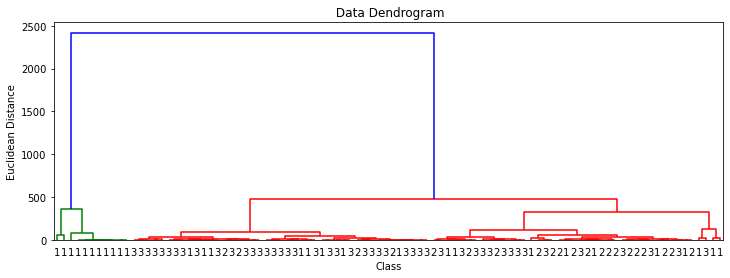

In [45]:
den_fig = plt.figure(figsize=(12,4))
ax = plt.subplot(111)
z = clust.hierarchy.linkage(raw_metrics[max_clique], 'ward')
clust.hierarchy.dendrogram(z, ax = ax, labels = raw_metrics['Class Ima'].values)
plt.xticks(fontsize = 10, rotation = 'horizontal')
plt.ylabel('Euclidean Distance')
plt.xlabel('Class')
plt.title(' Data Dendrogram')

#den_fig.savefig('C:\\Users\\FELIPE\\Documents\\PREEMACS\\raw_data_dendrogram.png', dpi = 600)

In [ ]:
den_fig.savefig('/Users/labc02/Documents/PREEMACS/dendrogram_only_max_clique_metrics.png')

In [46]:
pca = PCA(n_components = 3)
pca_fit = pca.fit_transform(std_df[max_clique])
pca_df = pd.DataFrame(data = pca_fit, columns = ['PC1', 'PC2', 'PC3'])

In [48]:
colors = []
for ii in std_df['Class Ima']:
    if ii == 1:
        colors.append('C0')
    elif ii == 2:
        colors.append('C1')
    elif ii == 3:
        colors.append('C2')
    elif ii == 4:
        colors.append('C3')

Text(0.5, 0.98, 'Scaled Data PCA')

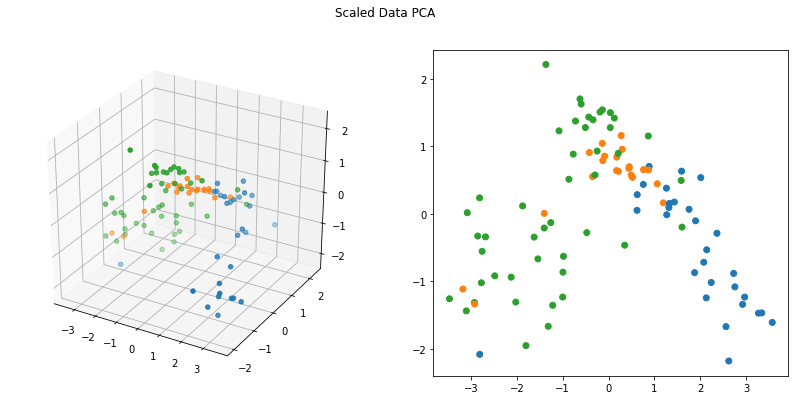

In [49]:
raw_pca = plt.figure(figsize=(14,6))
ax_3 = raw_pca.add_subplot(121, projection='3d')
ax_3.scatter(pca_df['PC1'], pca_df['PC3'], pca_df['PC2'], color = colors)
ax_2  = raw_pca.add_subplot(122)
ax_2.scatter(pca_df['PC1'], pca_df['PC2'], color = colors)
raw_pca.suptitle('Scaled Data PCA')

In [112]:
raw_pca.savefig('/Users/labc02/Documents/PREEMACS/PCA_max_clique_std_metrics.png', dpi = 600)

In [167]:
svc_accuracy = []
for ii in range(100):
    X_train, x_test, Y_train, y_test = train_test_split(std_df[max_clique], std_df['Class_3'], test_size = 0.2, random_state = ii)
    sv_clf.fit(X_train, Y_train)
    y_pred =sv_clf.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    svc_accuracy.append(accuracy)
    

In [163]:
sv_clf = svm.SVC(kernel = 'rbf')

In [164]:
sv_clf.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [165]:
y_pred =sv_clf.predict(x_test)

In [166]:
metrics.accuracy_score(y_test, y_pred)
#metrics.precision_score(y_test, y_pred)
#metrics.recall_score(y_test, y_pred)

1.0

In [180]:
model_acc = pd.Series([np.round(ii, 2) for ii in svc_accuracy])

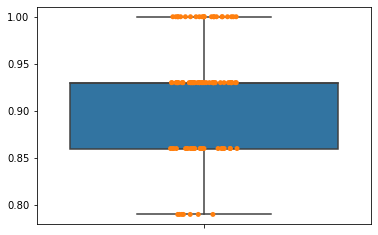

In [183]:
sns.boxplot(model_acc, orient = 'v')
sns.stripplot(model_acc, orient = 'v', color = 'C1')

In [179]:
pd.Series(svc_accuracy)

0     0.928571
1     0.928571
2     0.857143
3     0.857143
4     0.928571
        ...   
95    1.000000
96    0.928571
97    0.928571
98    0.928571
99    0.928571
Length: 100, dtype: float64

## Metrics Selection

### Univariate Selection

In [123]:
X_ = std_df.iloc[:,3:] # features columns
y = std_df['Class Ima'] # Target column

In [124]:
all_metrics = raw_metrics.iloc[:,3:].shape[1]

In [109]:
best_fts = fs.SelectKBest(score_func = fs.f_classif, k = all_metrics)
fit = best_fts.fit(X_, y)
f_scores = pd.DataFrame({'Metrics':X_.columns, 'Score':-np.log10(fit.pvalues_) })

In [110]:
f_scores = f_scores.sort_values('Score', ascending = False)

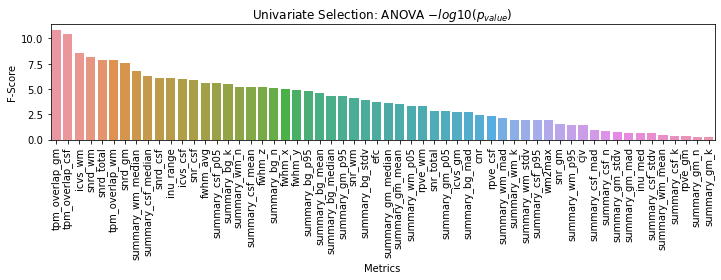

In [111]:
fsc_fig = plt.figure(figsize = (10, 4))
sns.barplot(y = 'Score', x = 'Metrics', data = f_scores, orient = 'v', order = f_scores['Metrics'])
plt.xticks(rotation = 90)
plt.ylabel('F-Score')
plt.title(r'Univariate Selection: ANOVA $-log10(p_{value})$')
plt.tight_layout()

In [112]:
fsc_fig.savefig('/Users/labc02/Documents/PREEMACS/univariate_sel_raw.png', dpi = 600)

### Feature Importance

In [113]:
model = ETC()

In [125]:
model.fit(X_, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [126]:
ftimp_df = pd.DataFrame({'Metric':X_.columns, 'Importance':model.feature_importances_})
ftimp_df.sort_values('Importance', ascending = False, inplace = True)

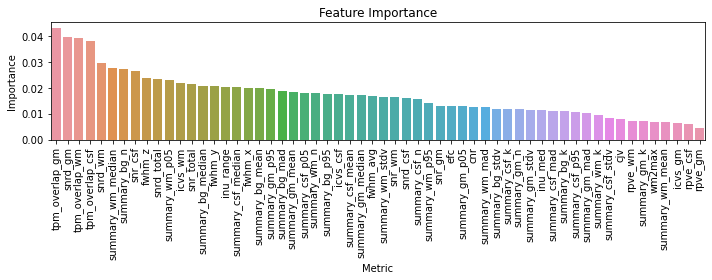

In [127]:
fimp_fig = plt.figure(figsize = (10, 4))
sns.barplot(x = 'Metric', y = 'Importance', data = ftimp_df, orient = 'v', order = ftimp_df['Metric'])
plt.xticks(rotation = 90)
plt.title('Feature Importance')
plt.tight_layout()

In [128]:
fimp_fig.savefig('/Users/labc02/Documents/PREEMACS/feature_importance_std.png', dpi = 600)

### Crosscorrelation

In [172]:
X = raw_metrics.iloc[:,2:]

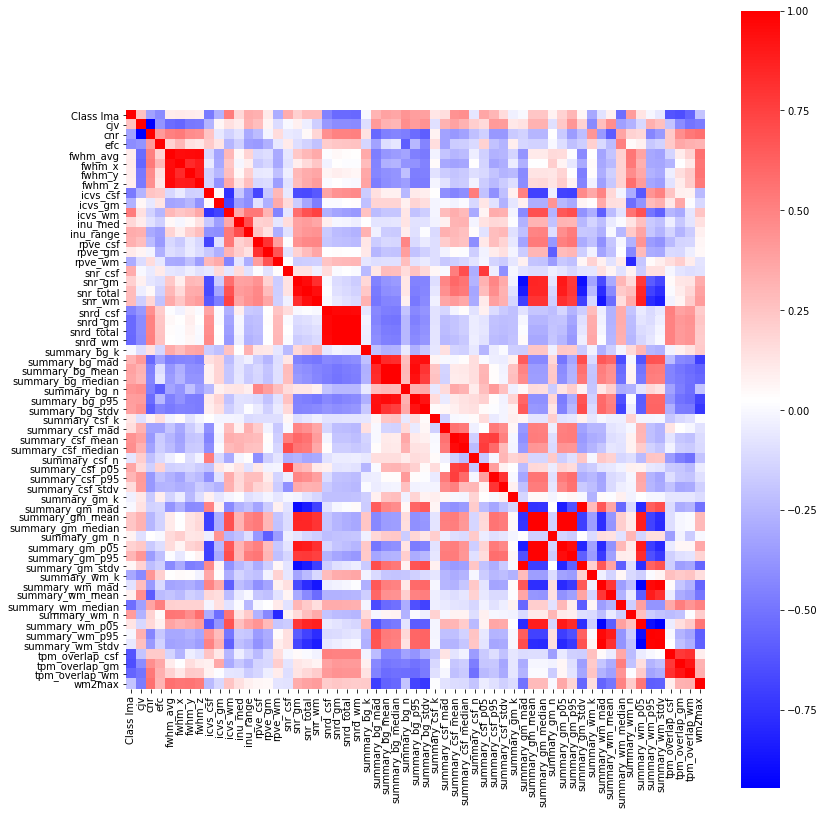

In [173]:
mcor_fig = plt.figure(figsize=(12,12))
sns.heatmap(X.corr(), cmap = 'bwr', square = True, xticklabels = X.columns, yticklabels = X.columns)
plt.tight_layout()

In [165]:
mcor_fig.savefig('/Users/labc02/Documents/PREEMACS/croscorr_std.png', dpi = 600)

In [218]:
corrmat = X.corr('spearman')

In [219]:
class_cor = corrmat['Class Ima'].sort_values()

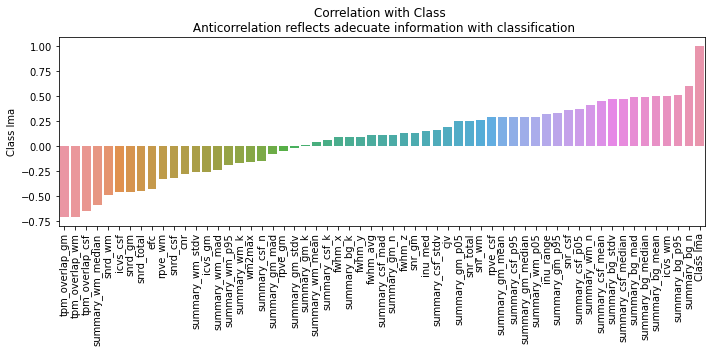

In [220]:
corr_fig = plt.figure(figsize=(10, 5))
sns.barplot(x = class_cor.index, y = class_cor)
plt.xticks(rotation=90)
plt.title('Correlation with Class \n Anticorrelation reflects adecuate information with classification')
plt.tight_layout()

In [177]:
corr_fig.savefig('/Users/labc02/Documents/PREEMACS/CorrWithClass_raw.png', dpi = 600)

In [221]:
class_cor.drop('Class Ima', inplace = True)

In [222]:
z_corr = (class_cor-class_cor.mean())/class_cor.std()

In [223]:
cor_df = pd.concat([class_cor, z_corr], axis = 1)
cor_df.columns = ['Corr', 'Z-score']
cor_df['z_abs'] = cor_df['Z-score'].abs()

In [229]:
from scipy.stats import spearmanr

In [231]:
rho_mat, p_mat = spearmanr(X, X)

In [306]:
rho_mat = np.empty((59,59))
p_mat = np.empty((59,59))                  
for idx, column in enumerate(X.columns):
    for ids, colms in enumerate(X.columns):
        rho, p_ = spearmanr(X[column], X[colms])
        p_mat[idx, ids] = -np.log10(p_)
        rho_mat[idx, ids] = rho

<ipython-input-306-d9b6ef1a4f84>:6: RuntimeWarning: divide by zero encountered in log10
  p_mat[idx, ids] = -np.log10(p_)


In [333]:
rho_df = pd.DataFrame(data = rho_mat, columns = X.columns, index = X.columns)

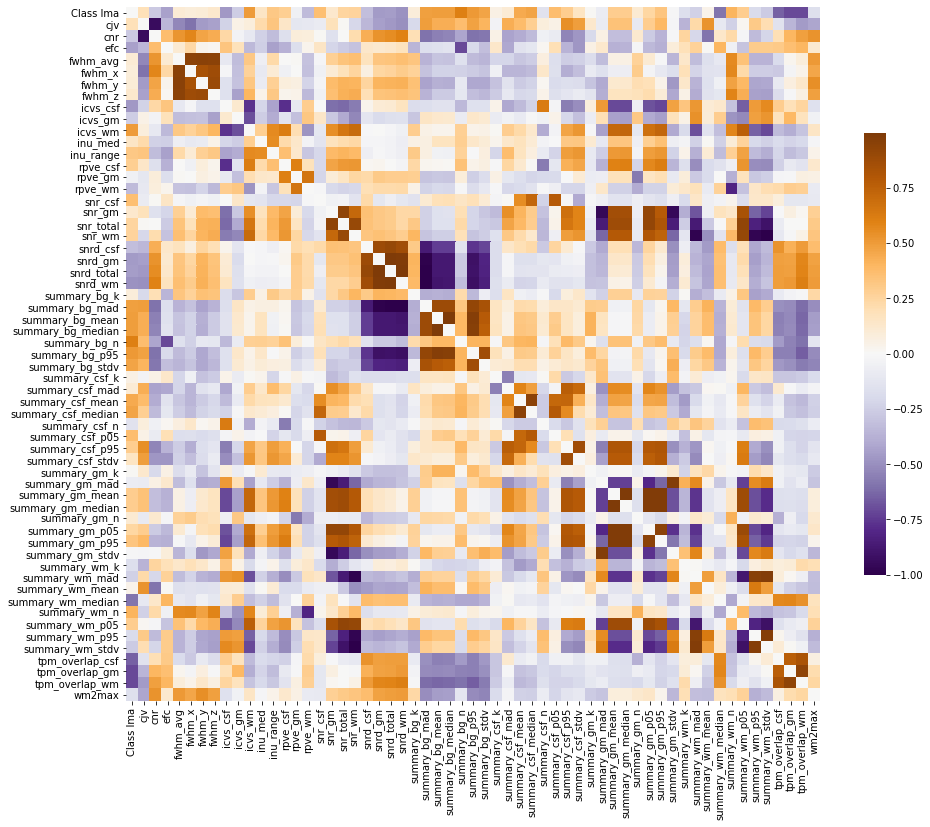

In [395]:
plt.figure(figsize=(14,12))
sns.heatmap(rho_df, square = True, cmap = 'PuOr_r', cbar_kws={"shrink": .6})
plt.tight_layout()

In [322]:
p_df = pd.DataFrame(data = p_mat, columns = X.columns, index = X.columns)

In [389]:
class_df = pd.concat([rho_df['Class Ima'], p_df['Class Ima']], axis=1)
class_df.columns = ['Rho', 'p_val']
class_df.sort_values('Rho', inplace = True)

Text(0, 0.5, '$-log10(p)$')

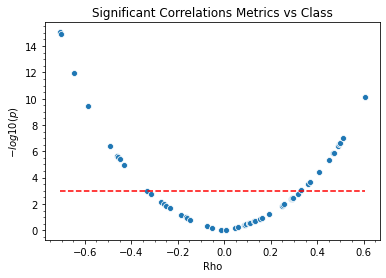

In [394]:
plt.figure()
sns.scatterplot(x = 'Rho', y='p_val', data=class_df)
plt.hlines(3, class_df['Rho'].min(), class_df['Rho'].max(), colors = 'r', linestyle = '--')
plt.minorticks_on()
plt.title('Significant Correlations Metrics vs Class')
plt.xlabel('Rho')
plt.ylabel(r'$-log10(p)$')

In [417]:
Cor_g = nx.Graph()
Cor_g.add_nodes_from(rho_df.columns)
for ii in p_df.columns:
    for jj in p_df.index:
        if p_df.loc[ii, jj] >= 3:
            Cor_g.add_edge(ii, jj, weight = (1-np.round(np.abs(rho_df.loc[ii, jj]),2)))

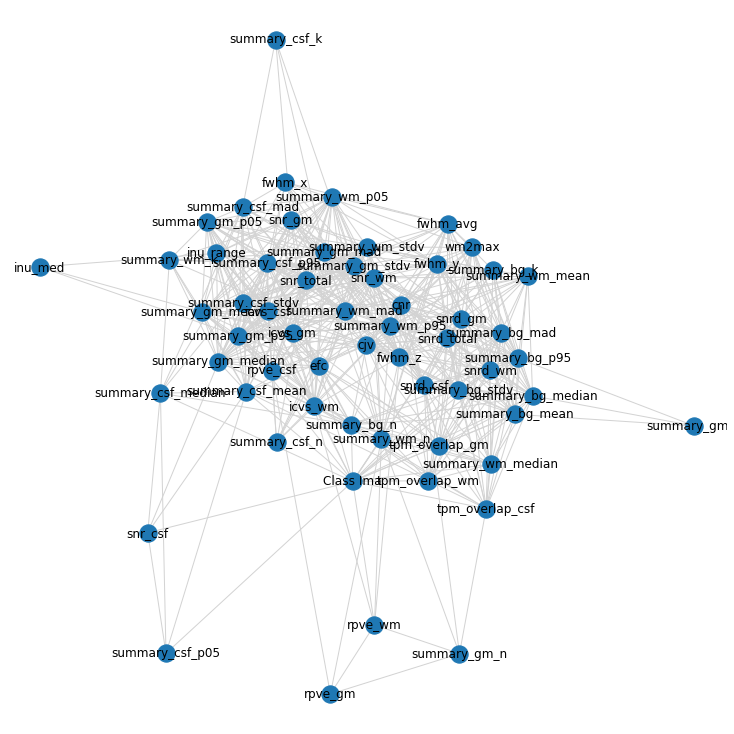

In [419]:
plt.figure(figsize=(10,10))
nx.draw_spring(Cor_g, with_labels = True, edge_color = 'lightgray')

In [290]:
clique_class = []
for ii in clique.cliques_containing_node(Cor_g, nodes = 'Class Ima'):
    temp_largest = len(ii)
    

[['summary_wm_median', 'Class Ima', 'summary_wm_n'],
 ['summary_wm_median',
  'Class Ima',
  'tpm_overlap_wm',
  'tpm_overlap_gm',
  'summary_bg_p95',
  'summary_bg_stdv',
  'tpm_overlap_csf',
  'summary_bg_mean',
  'summary_bg_median',
  'summary_bg_n'],
 ['summary_wm_median',
  'Class Ima',
  'tpm_overlap_wm',
  'tpm_overlap_gm',
  'summary_bg_p95',
  'summary_bg_stdv',
  'tpm_overlap_csf',
  'summary_bg_mean',
  'summary_bg_median',
  'snrd_wm',
  'snrd_total',
  'snrd_gm',
  'summary_bg_mad'],
 ['summary_wm_median',
  'Class Ima',
  'tpm_overlap_wm',
  'tpm_overlap_gm',
  'efc',
  'summary_bg_n'],
 ['tpm_overlap_csf', 'icvs_wm', 'tpm_overlap_gm', 'Class Ima'],
 ['summary_csf_p05',
  'snr_csf',
  'summary_csf_mean',
  'summary_csf_median',
  'Class Ima'],
 ['rpve_wm', 'summary_wm_n', 'icvs_wm', 'Class Ima'],
 ['efc', 'summary_gm_p95', 'icvs_csf', 'Class Ima', 'icvs_wm'],
 ['efc', 'summary_gm_p95', 'icvs_csf', 'Class Ima', 'summary_bg_n'],
 ['efc', 'tpm_overlap_gm', 'icvs_wm', 'Class